# **Analysis of models trained on MNIST classification**
Author: patrick.mccarthy@dtc.ox.ac.uk

In [164]:
from pathlib import Path
import pickle
import glob
import os
import copy

import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib import colormaps as cm
from scipy.special import softmax
from scipy.linalg import svd
from sklearn import svm
from sklearn.decomposition import KernelPCA, PCA
from scipy.stats import entropy

from thalamocortex.models import CTCNet
from thalamocortex.utils import create_data_loaders, activation_hook, get_neuron_weights, plot_receptive_field

In [101]:
save_path = ""

### **Load results**

In [102]:
results_paths = {
    "ff_MNIST": "/Users/patmccarthy/Documents/thalamocortex/results/06_03_25_feedforward_mnist/0_CTCNet_TC_none",
    # "driver_MNIST": "/Users/patmccarthy/Documents/thalamocortex/results/11_03_25_driver_mnist/...",
    # "mod1_MNIST": "/Users/patmccarthy/Documents/thalamocortex/results/11_03_25_mod1_mnist/...",
    # "mod2_MNIST": "/Users/patmccarthy/Documents/thalamocortex/results/11_03_25_mod2_mnist/...",
}

In [103]:
# load models, learning stats, results 
results = {}
for model_name, path in results_paths.items():
    
    # NOTE: note loading trained models because can instantiate from final weights

    # hyperparameters
    with open(Path(f"{path}", "hyperparams.pkl"), "rb") as handle:
        hp = pickle.load(handle)

    # learning progress
    with open(Path(f"{path}", "learning.pkl"), "rb") as handle:
        learning = pickle.load(handle)

    # store results and params in dict
    results[model_name] = {"val_losses": learning["val_losses"],
                           "train_losses": learning["train_losses"],
                           "val_topk_accs": learning["val_topk_accs"],
                           "train_topk_accs": learning["train_topk_accs"],
                           "train_time": learning["train_time"],
                           "state_dicts": learning["state_dicts"],
                           "hyperparams": hp}
    
    n_epochs = len(learning["val_losses"])

    # get top-1 accuracies in more convenient form for plotting
    train_top1_accs = []
    # val_top1_accs = []
    for epoch in range(n_epochs):
        train_top1_accs.append(learning["train_topk_accs"][epoch][1])
        # val_top1_accs.append(learning["val_topk_accs"][epoch][1])

    results[model_name]["train_top1_accs"] = np.array(train_top1_accs)
    # results[model_name]["val_top1_accs"] = np.array(val_top1_accs)
    

### **Learning progress**

In [104]:
model_plot_list = ["ff_MNIST"]

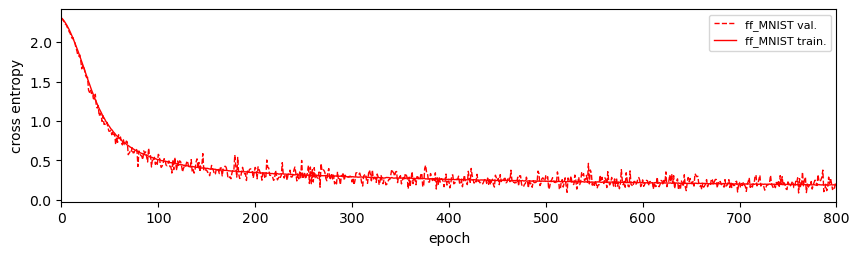

In [105]:
# loss through time
n_epochs = len(results[model_plot_list[0]]["val_losses"])
colours = ["r", "g", "b", "m"]
fig, ax = plt.subplots(1, 1, figsize=(10, 2.5))
models_plotted = []
models_plotted_idx = 0
for _, (model_name, model_results) in enumerate(results.items()):
    if model_name in model_plot_list:
        models_plotted.append(model_name)
        models_plotted_idx += 1

        n_epochs = len(model_results["val_losses"])

        ax.plot(np.arange(n_epochs), np.median(np.array(model_results["val_losses"]), axis=-1), ls="--", linewidth=1, label=f"{model_name} val.", c=colours[models_plotted_idx-1])
        ax.plot(np.arange(n_epochs), np.median(np.array(model_results["train_losses"]), axis=-1), ls="-", linewidth=1, label=f"{model_name} train.", c=colours[models_plotted_idx-1])

# ax.set_xticks(range(1, len(models_plotted)+1), models_plotted)
ax.set_ylabel("cross entropy")
ax.set_xlabel("epoch")
ax.set_xlim(0, n_epochs)
ax.legend(fontsize=8,  loc="upper right")
# ax.set_ylim(0, 0.2)

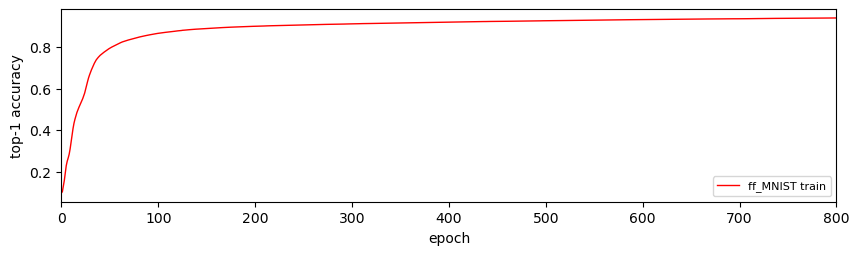

In [106]:
# accuracy through time
n_epochs = len(results[model_plot_list[0]]["val_losses"])
colours = ["r", "g", "b", "m"]
fig, ax = plt.subplots(1, 1, figsize=(10, 2.5))
models_plotted = []
models_plotted_idx = 0
for _, (model_name, model_results) in enumerate(results.items()):
    if model_name in model_plot_list:
        models_plotted.append(model_name)
        models_plotted_idx += 1

        n_epochs = len(model_results["val_losses"])

        # ax.plot(np.arange(n_epochs), np.array(model_results["val_top1_accs"]),ls="--", label=f"{model_name} val.", linewidth=1, c=colours[models_plotted_idx-1])
        ax.plot(np.arange(n_epochs), np.array(model_results["train_top1_accs"]), ls="-", label=f"{model_name} train", linewidth=1, c=colours[models_plotted_idx-1])

# ax.set_xticks(range(1, len(models_plotted)+1), models_plotted)
ax.set_ylabel("top-1 accuracy")
ax.set_xlabel("epoch")
ax.set_xlim(0, n_epochs)
ax.legend(fontsize=8, loc="lower right")
# ax.set_ylim(0, 0.2)

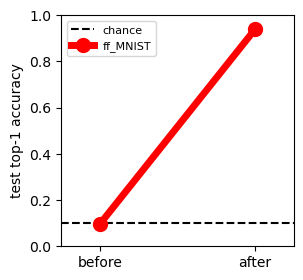

In [108]:
# accuracy before and after convergence
fig, ax = plt.subplots(1, 1, figsize=(3, 3))
ax.axhline(0.1, ls="--", c="k", label="chance")
for _, (model_name, model_results) in enumerate(results.items()):
    if model_name in model_plot_list:
        ax.plot([0, 1], [model_results["train_top1_accs"][0], model_results["train_top1_accs"][-1]], c=colours[models_plotted_idx-1], marker="o", markersize=10, linewidth=5, label=model_name)
ax.set_ylabel("test top-1 accuracy")
ax.set_ylim(0, 1)
ax.set_xlim(-0.25, 1.25)
ax.set_xticks([0, 1])
ax.set_xticklabels(["before", "after"])
ax.legend(fontsize=8, loc="upper left")

### **Trained model analysis**

In [109]:
models_selected = ["ff_MNIST"]

In [110]:
# epoch of trained model weights to use 
epoch_trained = 800

Test set inference

In [111]:
# create loaders
trainset_loader, testset_loader, metadata = create_data_loaders(dataset=results[models_selected[0]]["hyperparams"]["dataset"],
                                                                norm=results[models_selected[0]]["hyperparams"]["norm"],
                                                                batch_size=32,
                                                                save_path="/Users/patmccarthy/Documents/ThalamoCortex/data")


In [112]:
# load full test set
X_all = []
y_all = []
for X, y in iter(testset_loader):
    # X_all.append(X.detach().numpy()[:, 0, :, :])
    # y_all.append(y.detach().numpy()[:])
    X_all.append(X[:, :, :])
    y_all.append(y[:])
if results[models_selected[0]]["hyperparams"]["dataset"] in ["BinaryMNIST", "LeftRightMNIST"]:
    # Concatenate along the first axis (num_samples)
    X_all_arr = np.concatenate(X_all, axis=0)  # Shape: (num_samples, 1, 28, 28)
    y_all_reshaped = np.concatenate(y_all, axis=0)  # Shape: (num_samples,)

    # Reshape X to [samples, features]
    X_all_reshaped = X_all_arr.reshape(X_all_arr.shape[0], -1)  # Shape: (num_samples, 28*28)
else:
    X_all_tensor = torch.cat(X_all, dim=0)  # Shape: [num_samples, 1, 28, 28]
    y_all_tensor = torch.cat(y_all, dim=0)  # Shape: [num_samples]

    # Convert to NumPy
    X_all_arr = X_all_tensor.numpy()  # Shape: (num_samples, 1, 28, 28)
    y_all_reshaped = y_all_tensor.numpy()  # Shape: (num_samples,)

    # Reshape X to [samples, features]
    X_all_reshaped = X_all_arr.reshape(X_all_arr.shape[0], -1)  # Shape: (num_samples, 28*28)

In [115]:
# inference on full test set using models trained to various epochs
epochs_range = np.arange(0, 800, 25)
activations = {}
for model_selected in models_selected:
    activations[model_selected] = {}

    # instantiate model
    model = CTCNet(input_size=results[model_selected]["hyperparams"]["input_size"],
                   output_size=results[model_selected]["hyperparams"]["output_size"],
                   ctx_layer_size=results[model_selected]["hyperparams"]["ctx_layer_size"],
                   thal_layer_size=results[model_selected]["hyperparams"]["thal_layer_size"],
                   thalamocortical_type=results[model_selected]["hyperparams"]["thalamocortical_type"],
                   thal_reciprocal=results[model_selected]["hyperparams"]["thal_reciprocal"],
                   thal_to_readout=results[model_selected]["hyperparams"]["thal_to_readout"], 
                   thal_per_layer=results[model_selected]["hyperparams"]["thal_per_layer"])
    
    for epoch in epochs_range:
        activations[model_selected][epoch] = {}

        # get model trained to specified epoch
        weights = results[model_selected]["state_dicts"][epoch]

        # set model weights
        model.load_state_dict(weights)

        # Register hooks for specific layers
        hook_handles = []
        activations_this_epoch = {}
        for name, layer in model.named_modules():
            handle = layer.register_forward_hook(lambda module, input, output: activation_hook(module, input, output, activations_this_epoch))
            hook_handles.append(handle)
        
        # inference (on full dataset)
        with torch.no_grad():
            
            y_est_logits = model(torch.Tensor(X_all_reshaped))
            y_est_prob = softmax(y_est_logits.detach().numpy())
            y_est = np.argmax(y_est_prob, axis=1)

            # Remove hooks after use
            for handle in hook_handles:
                handle.remove()
        
        activations[model_selected][epoch] = copy.deepcopy(activations_this_epoch)

In [116]:
# define readable names for connections of interest
# NOTE: always double check these before usimng
# readable_names = {"ctx1": list(activations["ff_MNIST"][0].keys())[2],
#                   "ctx2": list(activations["ff_MNIST"][0].keys())[5],
#                   "ctx_readout": list(activations["ff_MNIST"][0].keys())[7]
#                 #   "thal": list(activations["ff_MNIST"][0].keys())[10], # TODO: figure out why thal layer not showing up in activations dict
# }
readable_layer_idxs = {"ctx1": 2,
                       "ctx2": 5,
                       "ctx_readout": 7
                #   "thal": 10, # TODO: figure out why thal layer not showing up in activations dict
}

In [117]:
# activations decoding analysis 
layers_selected = ["ctx1", "ctx2"]
train_test_split = 0.8
accuracies = {}
for layer_selected in layers_selected:
    accuracies[layer_selected] = {}
    for model_selected in models_selected:
        print(f"Decoding for {layer_selected}, {model_selected}")
        accuracies[layer_selected][model_selected] = {}
        for epoch in epochs_range:

            # select layer activations to decode from
            features = activations[model_selected][epoch][list(activations[model_selected][epoch].keys())[readable_layer_idxs[layer_selected]]].detach().numpy()

            # split into train and test set
            test_cutoff = int(len(features) * train_test_split)
            X_train = features[:test_cutoff, :]
            X_test = features[test_cutoff:, :]
            y_train = y_all_reshaped[:test_cutoff]
            y_test = y_all_reshaped[test_cutoff:]

            # TODO: perform cross-validation
            # TODO: try replacing with linear classifier
            
            # train SVM classifier
            clf = svm.SVC(kernel="linear")
            clf.fit(X_train, y_train)

            # test SVM classifier
            y_pred = clf.predict(X_test)
            
            # compute classification accuracy
            correct = 0
            for samp_idx in range(y_pred.shape[0]):
                if y_pred[samp_idx] == y_test[samp_idx]:
                    correct += 1
            accuracy = correct / y_pred.shape[0]
            print(f"epoch: {epoch}, accuracy: {accuracy * 100:.2f}%")

            accuracies[layer_selected][model_selected][epoch] = accuracy

Decoding for ctx1, ff_MNIST
epoch: 0, accuracy: 72.10%
epoch: 25, accuracy: 90.65%
epoch: 50, accuracy: 90.95%
epoch: 75, accuracy: 91.10%
epoch: 100, accuracy: 91.65%
epoch: 125, accuracy: 91.90%
epoch: 150, accuracy: 92.10%
epoch: 175, accuracy: 92.45%
epoch: 200, accuracy: 92.75%
epoch: 225, accuracy: 92.85%
epoch: 250, accuracy: 92.80%
epoch: 275, accuracy: 93.05%
epoch: 300, accuracy: 93.20%
epoch: 325, accuracy: 93.10%
epoch: 350, accuracy: 93.30%
epoch: 375, accuracy: 93.45%
epoch: 400, accuracy: 93.30%
epoch: 425, accuracy: 93.50%
epoch: 450, accuracy: 93.85%
epoch: 475, accuracy: 93.75%
epoch: 500, accuracy: 93.75%
epoch: 525, accuracy: 93.80%
epoch: 550, accuracy: 94.05%
epoch: 575, accuracy: 94.35%
epoch: 600, accuracy: 94.30%
epoch: 625, accuracy: 94.25%
epoch: 650, accuracy: 94.35%
epoch: 675, accuracy: 94.40%
epoch: 700, accuracy: 94.35%
epoch: 725, accuracy: 94.45%
epoch: 750, accuracy: 94.45%
epoch: 775, accuracy: 94.40%
Decoding for ctx2, ff_MNIST
epoch: 0, accuracy: 5

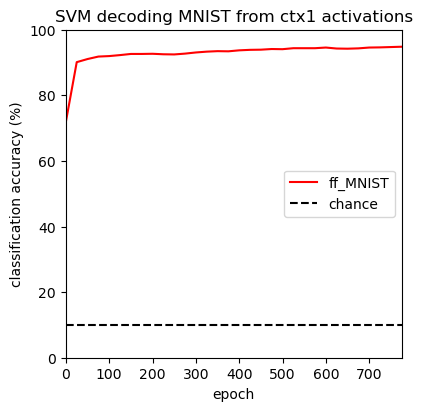

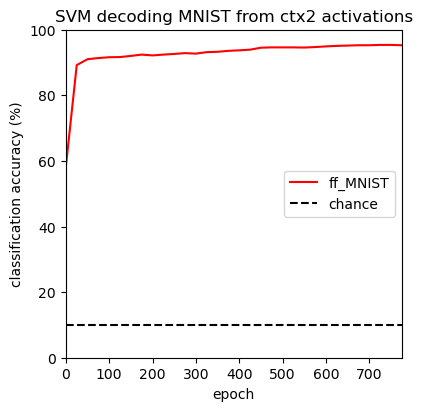

In [90]:
for layer in accuracies.keys():
    fig, ax = plt.subplots(1, 1, figsize=(4, 4), layout="constrained")
    for model_idx, model_selected in enumerate(accuracies[layer].keys()):
        ax.plot(accuracies[layer][model_selected].keys(), np.array(list(accuracies[layer][model_selected].values())) * 100, c=colours[model_idx], label=model_selected)
    ax.axhline(10, ls="--", c="k", label="chance")
    ax.set_title(f"SVM decoding MNIST from {layer} activations")
    ax.set_ylabel("classification accuracy (%)")
    ax.set_xlabel("epoch")
    ax.set_ylim(0, 100)
    ax.set_xlim(list(accuracies[layer][model_selected].keys())[0], list(accuracies[layer][model_selected].keys())[-1])
    ax.legend(loc="center right")
    fig.patch.set_facecolor("w")
    # fig.savefig(Path(save_path, f"svm_decoding_through_time_{layer_select}_epoch{epoch}.png"), dpi=200)

In [120]:
accuracies.keys()

dict_keys(['ctx1', 'ctx2'])

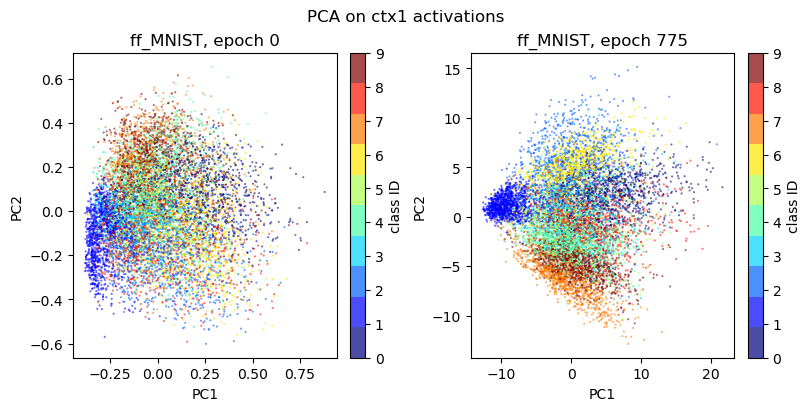

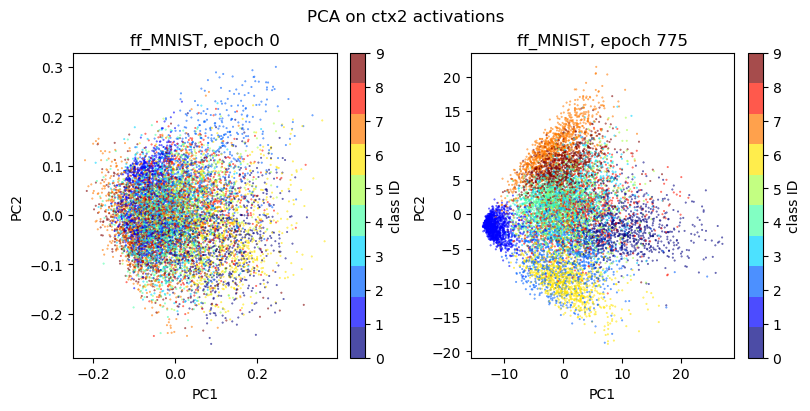

In [128]:
# activations analysis
reduction_method = "PCA"
kernel = "rbf"
epochs = [0, 775]

# generate colourmap
jet_cmap = plt.colormaps["jet"]  
N = 10
colors = jet_cmap(np.linspace(0, 1, N)) 
discrete_cmap = mcolors.ListedColormap(colors)

for layer in accuracies.keys():
    fig, ax = plt.subplots(len(accuracies[layer]), len(epochs), figsize=(4 * len(epochs), 4 * len(accuracies[layer])), layout="constrained")
    for model_idx, model_selected in enumerate(accuracies[layer].keys()):

        for epoch_idx, epoch in enumerate(epochs):

            features = activations[model_selected][epoch][list(activations[model_selected][epoch].keys())[readable_layer_idxs[layer]]].detach().numpy()

            if reduction_method == "PCA":
                pca = PCA(n_components=2)
                activations_2d = pca.fit_transform(features)
                title = f"{reduction_method} on {layer} activations"
            elif reduction_method == "KernelPCA":
                pca_transformer = KernelPCA(n_components=2, kernel="cosine")
                activations_2d = pca_transformer.fit_transform(features)
                title = f"{reduction_method} on {layer} activations\nwith {kernel} kernel (epoch {epoch})"

            scatter = ax[epoch_idx].scatter(activations_2d[:, 0], activations_2d[:, 1], c=y_all_reshaped, cmap=discrete_cmap, alpha=0.7, s=0.2)
            plt.colorbar(scatter, label="class ID")
            ax[epoch_idx].set_title(f"{model_selected}, epoch {epoch}")
            ax[epoch_idx].set_xlabel("PC1")
            ax[epoch_idx].set_ylabel("PC2")

    fig.suptitle(title)
    fig.patch.set_facecolor("w")
    # fig.savefig(Path(save_path, f"kernel_pca_{kernel}_activations_{layer_select}_epoch{epoch}.png"), dpi=200)


In [194]:
# define readable names for connections of interest
# NOTE: always double check these before using
readable_weight_idxs = {"input_to_ctx1": 2,
                       "ctx1_to_ctx2": 4,
                #   "thal": ?, # TODO: figure out why thal layer not showing up in activations dict
}
readable_weight_names = {"input_to_ctx1": "ctx1.0.weight"}

In [189]:
# weight decomposition analysis
weights_selected = ["input_to_ctx1", "ctx1_to_ctx2"]
svds = {}
for weights_select in weights_selected:
    svds[weights_select] = {}
    for model_selected in models_selected:
        svds[weights_select][model_selected] = {}
        accuracies[layer_selected][model_selected] = {}
        activations[model_selected] = {}
        for epoch in epochs_range:

            # get weights in forward pass direction and compute spectral measures
            weights = results[model_selected]["state_dicts"][epoch][list(results[model_selected]["state_dicts"][epoch].keys())[readable_weight_idxs[weights_select]]]

            # SVD on weights
            U, s, Vh = svd(weights)
            s_norm = s / np.sum(s)
            
            # compute spectral metrics
            spectral_entropy = entropy(s_norm)
            spectral_norm = np.max(s)
            condition_number = np.max(s) / np.min(s)
            
            # store
            svds[weights_select][model_selected][epoch] = {"U": U,
                                                           "s": s,
                                                           "Vh": Vh,
                                                           "s_norm": s_norm,
                                                           "spectral_entropy": spectral_entropy,
                                                           "spectral_norm": spectral_norm,
                                                           "condition_number": condition_number}

            print(f"{weights.shape=}")
            print(f"{Vh.shape=}")

weights.shape=torch.Size([32, 784])
Vh.shape=(784, 784)
weights.shape=torch.Size([32, 784])
Vh.shape=(784, 784)
weights.shape=torch.Size([32, 784])
Vh.shape=(784, 784)
weights.shape=torch.Size([32, 784])
Vh.shape=(784, 784)
weights.shape=torch.Size([32, 784])
Vh.shape=(784, 784)
weights.shape=torch.Size([32, 784])
Vh.shape=(784, 784)
weights.shape=torch.Size([32, 784])
Vh.shape=(784, 784)
weights.shape=torch.Size([32, 784])
Vh.shape=(784, 784)
weights.shape=torch.Size([32, 784])
Vh.shape=(784, 784)
weights.shape=torch.Size([32, 784])
Vh.shape=(784, 784)
weights.shape=torch.Size([32, 784])
Vh.shape=(784, 784)
weights.shape=torch.Size([32, 784])
Vh.shape=(784, 784)
weights.shape=torch.Size([32, 784])
Vh.shape=(784, 784)
weights.shape=torch.Size([32, 784])
Vh.shape=(784, 784)
weights.shape=torch.Size([32, 784])
Vh.shape=(784, 784)
weights.shape=torch.Size([32, 784])
Vh.shape=(784, 784)
weights.shape=torch.Size([32, 784])
Vh.shape=(784, 784)
weights.shape=torch.Size([32, 784])
Vh.shape=(78

In [186]:
svds[weights_select][model_selected][epoch]["Vh"].shape

(32, 32)

In [167]:
weights_select = "input_to_ctx1"
model_select = "ff_MNIST"
epochs = [0, 775]

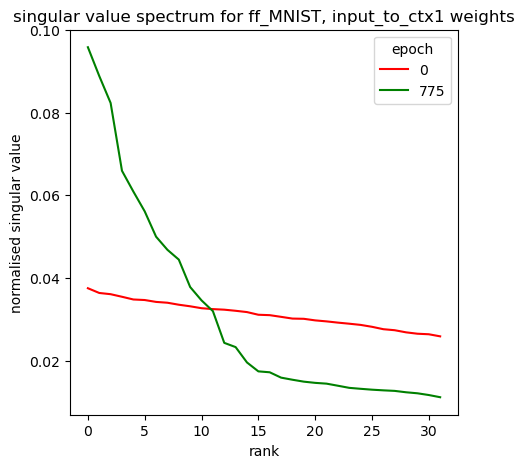

In [169]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
for epoch_idx, epoch in enumerate(epochs):
    ax.plot(svds[weights_select][model_select][epoch]["s_norm"], c=colours[epoch_idx], label=epoch)
ax.set_title(f"singular value spectrum for {model_select}, {weights_select} weights")
ax.set_ylabel("normalised singular value")
ax.set_xlabel("rank")
ax.legend(title="epoch")

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
for epoch_idx, epoch in enumerate(epochs):
    ax.plot(svds[weights_select][model_select][epoch]["s"], c=colours[epoch_idx], label=epoch)
ax.set_title(f"singular value spectrum for {model_select}, {weights_select} weights")
ax.set_ylabel("singular value")
ax.set_xlabel("rank")
ax.legend(title="epoch")

In [172]:
svds[weights_select][model_select][epoch]["s_norm"]

torch.Size([32, 784])

Text(0.5, 0.98, 'ff_MNIST input layer receptive fields at epoch 775')

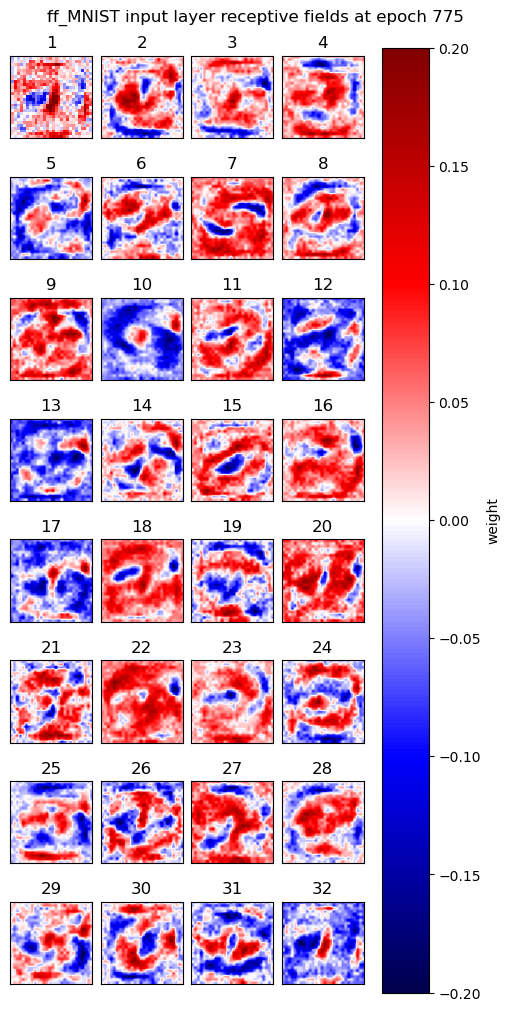

In [182]:
# receptive field analysis
cmap = cm.get_cmap("seismic")
clims = [-0.2, 0.2]
epoch = 775
fig, ax = plt.subplots(8, 4, figsize=(5, 10), layout="constrained")

for neuron_id in range(32):

    row_idx = neuron_id // 4
    col_idx = neuron_id % 4

    input_layer_weights = results[model_selected]["state_dicts"][epoch][list(results[model_selected]["state_dicts"][epoch].keys())[readable_weight_idxs["input_to_ctx1"]]]


    weights_this_neuron = get_neuron_weights(weights=input_layer_weights,
                                             neuron_id=neuron_id,
                                             shape=(28, 28))
    plot_receptive_field(weights=weights_this_neuron,
                         ax=ax[row_idx, col_idx],
                         cmap=cmap,
                         clims=clims,
                         title=neuron_id+1)

psm = ax[0, 0].pcolormesh(weights_this_neuron, cmap=cmap, rasterized=True, vmin=clims[0], vmax=clims[1])
cbar = fig.colorbar(psm, ax=ax)
cbar.set_label("weight")
fig.suptitle(f"{model_selected} input layer receptive fields at epoch {epoch}")
# fig.set_tight_layout(True)

Ablation analysis

In [225]:
# accuracy with ablated feedback connections
epoch = 775
activations = {}
weights_to_zero = "input_to_ctx1"
for model_selected in models_selected:
    activations[model_selected] = {}

    # instantiate model
    model = CTCNet(input_size=results[model_selected]["hyperparams"]["input_size"],
                    output_size=results[model_selected]["hyperparams"]["output_size"],
                    ctx_layer_size=results[model_selected]["hyperparams"]["ctx_layer_size"],
                    thal_layer_size=results[model_selected]["hyperparams"]["thal_layer_size"],
                    thalamocortical_type=results[model_selected]["hyperparams"]["thalamocortical_type"],
                    thal_reciprocal=results[model_selected]["hyperparams"]["thal_reciprocal"],
                    thal_to_readout=results[model_selected]["hyperparams"]["thal_to_readout"], 
                    thal_per_layer=results[model_selected]["hyperparams"]["thal_per_layer"])

    # get model trained to specified epoch
    weights = results[model_selected]["state_dicts"][epoch]

    # # set chosen weights to zero
    # selected_weights_shape = weights[readable_weight_names[weights_to_zero]].shape
    # new_weights = torch.zeros(selected_weights_shape)
    # weights[readable_weight_names[weights_to_zero]] = new_weights
    
    # set model weights
    model.load_state_dict(weights)

    # do inference on test set
    # register hooks for specific layers
    hook_handles = []
    activations_this_epoch = {}
    for name, layer in model.named_modules():
        handle = layer.register_forward_hook(lambda module, input, output: activation_hook(module, input, output, activations_this_epoch))
        hook_handles.append(handle)
    
    # inference (on full dataset)
    with torch.no_grad():
        
        y_est_logits = model(torch.Tensor(X_all_reshaped))
        y_est_prob = softmax(y_est_logits.detach().numpy())
        y_est = np.argmax(y_est_prob, axis=1)

        # Remove hooks after use
        for handle in hook_handles:
            handle.remove()
    
    # compute classification accuracy
    correct = 0
    for samp_idx in range(y_est.shape[0]):
        if y_est[samp_idx] == y_all_reshaped[samp_idx]:
            correct += 1
    accuracy = correct / y_est.shape[0]
    print(f"accuracy: {accuracy * 100:.2f}%")

    activations[model_selected][epoch] = copy.deepcopy(activations_this_epoch)

accuracy: 93.78%


TypeError: 'Axes' object is not subscriptable

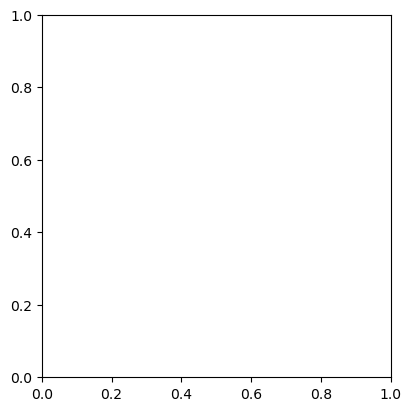

In [ ]:
# activations with ablated feedback
reduction_method = "PCA"
kernel = "rbf"
epochs = [0, 775]
# generate colourmap
jet_cmap = plt.colormaps["jet"]  
N = 10
colors = jet_cmap(np.linspace(0, 1, N)) 
discrete_cmap = mcolors.ListedColormap(colors)

for layer in accuracies.keys():
    fig, ax = plt.subplots(len(accuracies[layer]), len(epochs), figsize=(4 * len(epochs), 4 * len(accuracies[layer])), layout="constrained")
    for model_idx, model_selected in enumerate(accuracies[layer].keys()):

        for epoch_idx, epoch in enumerate(epochs):

            features = activations[model_selected][epoch][list(activations[model_selected][epoch].keys())[readable_layer_idxs[layer]]].detach().numpy()

            if reduction_method == "PCA":
                pca = PCA(n_components=2)
                activations_2d = pca.fit_transform(features)
                title = f"{reduction_method} on {layer} activations"
            elif reduction_method == "KernelPCA":
                pca_transformer = KernelPCA(n_components=2, kernel="cosine")
                activations_2d = pca_transformer.fit_transform(features)
                title = f"{reduction_method} on {layer} activations\nwith {kernel} kernel (epoch {epoch})"

            scatter = ax[epoch_idx].scatter(activations_2d[:, 0], activations_2d[:, 1], c=y_all_reshaped, cmap=discrete_cmap, alpha=0.7, s=0.2)
            plt.colorbar(scatter, label="class ID")
            ax[epoch_idx].set_title(f"{model_selected}, epoch {epoch}")
            ax[epoch_idx].set_xlabel("PC1")
            ax[epoch_idx].set_ylabel("PC2")

    fig.suptitle(title)
    fig.patch.set_facecolor("w")
    # fig.savefig(Path(save_path, f"kernel_pca_{kernel}_activations_{layer_select}_epoch{epoch}.png"), dpi=200)
